In [ ]:
from math import factorial
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
#### diffusion
def von_neumann_neighborhood(coordinate, boundary_conditions):
    if boundary_conditions == 'periodic':
        i, j = coordinate
        return ((i - 1) % N, j), ((i + 1) % N, j), (i, (j - 1) % M), (i, (j + 1) % M)
    else:
        print('unknown boundary conditions')

In [ ]:
### see Vanag, V. K. Probability Cellular Automaton-Aided Modeling of the Stirring Effect in the Autocatalytic Step of the Belousov−Zhabotinsky Reaction.
### J. Phys. Chem. 1996, 100 (27), 11336–11345. https://doi.org/10.1021/jp960539c
# probability of division of molecules in 2 cells

def vanag_probability(k, m, r, s, q):
    # r and s are how many molecules were in the cells
    # k and m are how many molecules are now in the cells
    # q is the ratio of the cell volume to the sum of the volumes of two cells
    return factorial(r + s) / (factorial(k) * factorial(m)) * q**k * (1 - q)**m # Eq. (7) in the above-cited paper

In [ ]:
### see Vanag, V. K. Probability Cellular Automaton-Aided Modeling of the Stirring Effect in the Autocatalytic Step of the Belousov−Zhabotinsky Reaction.
### J. Phys. Chem. 1996, 100 (27), 11336–11345. https://doi.org/10.1021/jp960539c

def vanag_diffusion(r, s, q): # r and s are how many molecules were in the cells

    teta = np.random.uniform(0, 1) # random float 0.0 <= teta < 1.0

    sum = 0
## for each distribution of molecules in the 2 cells
    for h in range(0, r + s + 1):
        prob = vanag_probability(r + s - h, h, r, s, q)
        if sum < teta and teta <= sum + prob: # Eqs. (8) and (9) in the above-cited paper ...why prob?
            return (r + s - h, h) # returns how many molecules are now in the cells
        sum += prob

In [ ]:
def get_random_pair_within_block(nw_coordinate, position):
    # north-west coordinate of the block;
    # position is the coordinate of the first cell in the block
    # the function return a random pair of this first cell

    nw_i, nw_j = nw_coordinate
    movement = np.random.choice(['CW', 'CCW']) # CW = clockwise, CCW = counterclockwise

    if position == 'NW':
        position_coord = (nw_i, nw_j)
        if movement == 'CW':
            pair_coord = (nw_i, (nw_j + 1) % M)
        elif movement == 'CCW':
            pair_coord = ((nw_i + 1) % N, nw_j)

    elif position == 'NE':
        position_coord = (nw_i, (nw_j + 1) % M)
        if movement == 'CW':
            pair_coord = ((nw_i + 1) % N, (nw_j + 1) % M)
        elif movement == 'CCW':
            pair_coord = (nw_i, nw_j)

    elif position == 'SW':
        position_coord = ((nw_i + 1) % N, nw_j)
        if movement == 'CW':
            pair_coord = (nw_i, nw_j)
        elif movement == 'CCW':
            pair_coord = ((nw_i + 1) % N, (nw_j + 1) % M)

    elif position == 'SE':
        position_coord = ((nw_i + 1) % N, (nw_j + 1) % M)
        if movement == 'CW':
            pair_coord = ((nw_i + 1) % N, nw_j)
        elif movement == 'CCW':
            pair_coord = (nw_i, (nw_j + 1) % M)

    else:
        print('WARNING: unknown position')

    return (position_coord, pair_coord)

In [ ]:
def cell_type(cell_value):
    if cell_value >= FIRST_NODE_NUMBER:
        return 'polymer'
    elif cell_value <= MAX_SOLVENT_MOLECULES:
        return 'solvent'
    else:
        print(f'unknown cell type: {cell_value}')
        return 'unknown'

In [ ]:
#### defining energy of interactions
# parameters:
N = 30 # must be an even number... size
M = 30 # must be an even number...size

GEL_RADIUS = 3

MAX_SOLVENT_MOLECULES = 10
FIRST_NODE_NUMBER = 50  ### must be larger than MAX_SOLVENT_MOLECULES

VALUE_AT_EDGES = 0

energy_water_polymer = -3.0 # water is a good solvent - attractive interactions
energy_solvent_polymer = 2.0 # solvent here is actually a non-solvent - repulsive interaction
energy_polymer_polymer = 0.0 # no interaction
spring_constant = 10.0    # stiffness indicator (large k means stiff)

In [ ]:
# ### Test initial configurations

# lattice = np.zeros((N, M), dtype=np.uintc)

# # placing polymer particles

# lattice[1, 1] = FIRST_NODE_NUMBER
# lattice[1, 2] = FIRST_NODE_NUMBER + 1

In [ ]:
#### visualizing the lattice and molecule positions
### Initial configuration

lattice = np.zeros((N, M), dtype=np.uintc)

# setting up edge values
lattice[:, [0, -1]] = lattice[[0, -1]] = VALUE_AT_EDGES

# placing polymer in the middle
origin = (N // 2, M // 2)
node_number = FIRST_NODE_NUMBER

for x, y in np.ndindex(lattice.shape):
    if np.sqrt((origin[0] - x)**2 + (origin[1] - y)**2) <= GEL_RADIUS:
        lattice[x, y] = node_number
        node_number +=1

print(f'number of assigned nodes is: {node_number - FIRST_NODE_NUMBER - 1}')

number of assigned nodes is: 28


In [ ]:
### VISUALIZATION FOR MADRID

# lattice[1,1] = 1
# lattice[1,2] = 1
# lattice[2,1] = 1
# lattice[2,2] = 1

# lattice[0,0] = 1
# lattice[0,1] = 1
# lattice[1,0] = 1
# lattice[1,1] = 1

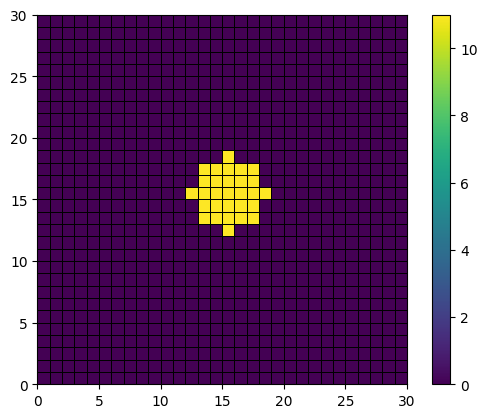

In [ ]:
# plt.imshow(lattice, interpolation='none')

# pc = plt.pcolormesh(lattice, edgecolors='k', linewidth=0.5)
pc = plt.pcolormesh(np.where(lattice < FIRST_NODE_NUMBER, lattice, MAX_SOLVENT_MOLECULES * 1.1), edgecolors='k', linewidth=0.5)  # why 1.1
ax = plt.gca()
ax.set_aspect('equal')
plt.colorbar(pc)

In [ ]:
#### Visualizing the network
# creating a graph for the gel

gel_graph = nx.Graph()

for i, j in np.ndindex(lattice.shape):
    if cell_type(lattice[i, j]) == 'polymer':
        if lattice[i, j] not in gel_graph.nodes: # adding new node
            gel_graph.add_node(lattice[i, j], coord=(i, j))

        nbs = von_neumann_neighborhood((i, j), 'periodic') # all von Neumann neighbors of the new node
        nbs = [n for n in nbs if cell_type(lattice[n]) == 'polymer'] # only von Neumann neighbors of the polymer
        # print('node: ', lattice[i, j])
        # print('Its von Neumann neighborhood:', [lattice[n] for n in nbs])

        for nb in nbs:
            if lattice[nb] not in gel_graph.nodes:
                gel_graph.add_node(lattice[nb], coord=nb) # adding new node

            if (lattice[i, j], lattice[nb]) not in gel_graph.edges:
                gel_graph.add_edge(lattice[i, j], lattice[nb]) # adding a new edge

In [ ]:
# c1 = gel_graph.nodes[FIRST_NODE_NUMBER]['coord']
# c2 = gel_graph.nodes[FIRST_NODE_NUMBER + 1]['coord']
# print(c1, c2)

# dist = np.sqrt((c1[0] - c2[0])**2 + (c1[1] - c2[1])**2)
# print(f'distance {dist}')

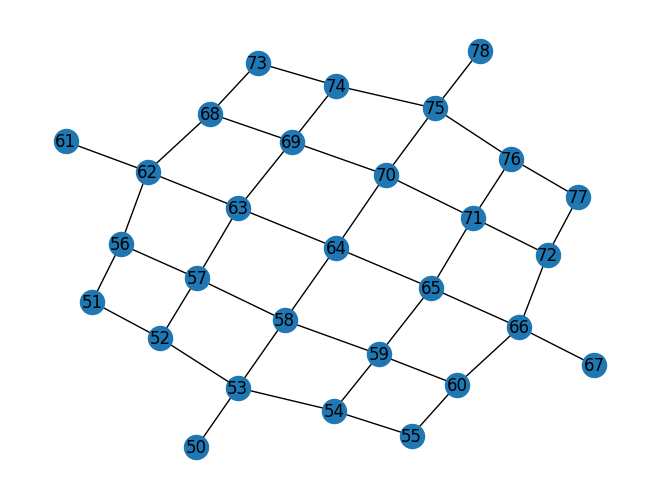

In [ ]:
nx.draw(gel_graph, with_labels=True) # font_weight='bold'

In [ ]:
# for node in gel_graph.nodes:
#     print(node, list(gel_graph.adj[node]))

In [ ]:
#### calculating energy of changing positions by diffusion
# creating two lists of NW coordinates for even and odd partitioning

NW_coord_block_even = []
NW_coord_block_odd = []

for i in range(0, N, 2):
    for j in range(0, M, 2):
        NW_coord_block_even.append((i, j))

for i in range(1, N + 1, 2):
    for j in range(1, M + 1, 2):
        NW_coord_block_odd.append((i, j))

NW_coord_all_blocks = NW_coord_block_even + NW_coord_block_odd

In [ ]:
def interaction_energy(central_cell, list_of_neighbors):
    # values of cells as input, not coordinates
    # three neigbors are to be passed to the function
    # function calculates molecular energy of the central cell with its three neighbors

    energy = 0.0

    if cell_type(central_cell) == 'solvent':
        x_1 = 1 - central_cell / MAX_SOLVENT_MOLECULES # water fraction
        x_2 = 1 - x_1 # solvent fraction
        only_polymer_cells = [x for x in list_of_neighbors if cell_type(x) == 'polymer'] # water and solvent can interact with polymer only
        for plm in only_polymer_cells:
            energy += energy_water_polymer * x_1 + energy_solvent_polymer * x_2 # simple mixing rule

    elif cell_type(central_cell) == 'polymer':

        for nb in list_of_neighbors:

            if cell_type(nb) == 'polymer':
                energy += energy_polymer_polymer

            elif cell_type(nb) == 'solvent':
                x_1 = 1 - nb / MAX_SOLVENT_MOLECULES # water fraction
                x_2 = 1 - x_1 # solvent fraction
                energy += energy_water_polymer * x_1 + energy_solvent_polymer * x_2 # simple mixing rule

    return energy

In [ ]:
def elastic_energy(node_coordinate, node_number):
    energy_elastic = 0.0
    x_0, y_0 = node_coordinate
    for adj_node in list(gel_graph.adj[node_number]): # iterate over all adjacent nodes; they are connected within the graph
        x, y = gel_graph.nodes[adj_node]['coord']
        dist = np.sqrt((x_0 - x)**2 + (y_0 - y)**2)
        # print(f'distance in initial state: {dist}')
        energy_elastic += 0.5 * spring_constant * (dist - 1.0)**2 # 1.0 is the distance in mechanical equlibrium
    return energy_elastic

In [ ]:
#### statistics
def stat_data():
# import copy

    # lattice_copy = copy.deepcopy(lattice)

    total_cells = 0
    total_solvent = 0
    solvent_cnt = 0

    for i in range(N):
        st, fn = 0, -1
        for j in range(M):
            if cell_type(lattice[i,j]) == 'polymer':
                if st == 0:
                    st = j
                    fn = j
                else:
                    fn = j
        # print(f'layer: {i}, border: {st} and {fn}')
        total_cells += len(lattice[i, st:fn+1])
        # print('layer:', i, len(lattice[i, st:fn+1]))

        for t in range(st, fn + 1):
            if cell_type(lattice[i, t]) == 'solvent':
                solvent_cnt += 1
                total_solvent += lattice[i, t]

    total_number_of_nodes = node_number - FIRST_NODE_NUMBER - 1
    s_start = np.sqrt(total_number_of_nodes / np.pi)
    s_swollen = np.sqrt(total_cells / np.pi)

    # print(f'Total number of gel cells {total_cells}')

    # print(f'Total number of nodes: {total_number_of_nodes}')
    # print(f'relative swelling: {s_swollen / s_start}')

    # print(f'solvent cells: {solvent_cnt}')
    # print(f'average concentration: {total_solvent / solvent_cnt}')

    if solvent_cnt == 0:
        return (s_swollen / s_start, total_solvent)
    else:
        return (s_swollen / s_start, total_solvent / solvent_cnt)

In [ ]:
#### Main code implementation
# NW = northwest, NE = northeast, SW = southwest, SE = southeast
# ---|---
# NW | NE
# ---|---
# SW | SE
# ---|---

# images_dir = '/content/drive/My Drive/Images/'

MAX_ITER = 500

start_coords_in_block = ['NW', 'NE', 'SW', 'SE']

cnt = 0

while cnt <= MAX_ITER:

    # if cnt % 2000 == 0 and cnt > 1:
    #     VALUE_AT_EDGES += 1

    for nw_coords in NW_coord_all_blocks:

        # randomly select a pair of cells within block
        position = np.random.choice(start_coords_in_block)
        p1, p2 = get_random_pair_within_block(nw_coords, position)

        if cell_type(lattice[p1]) == 'fixed' or cell_type(lattice[p2]) == 'fixed':
            continue

        if cell_type(lattice[p1]) == 'solvent' and cell_type(lattice[p2]) == 'solvent':
            ### DIFUSSION
            new_state_1, new_state_2 = vanag_diffusion(lattice[p1], lattice[p2], 1/2)

            if new_state_1 > MAX_SOLVENT_MOLECULES or new_state_2 > MAX_SOLVENT_MOLECULES:
                pass # to never exceed the max capacity of the cell
            else:
                lattice[p1], lattice[p2] = new_state_1, new_state_2 # otherwise diffusion takes place

        elif cell_type(lattice[p1]) == 'polymer' and cell_type(lattice[p2]) == 'polymer':
            ### POLYMER-POLYMER
            pass # no action

        else: ### POLYMER-SOLVENT INTERACTION
            if cell_type(lattice[p1]) == 'polymer':
                polymer_cell, solvent_cell = p1, p2
            else:
                polymer_cell, solvent_cell = p2, p1

            nbs1 = von_neumann_neighborhood(polymer_cell, 'periodic')
            nbs1 = [lattice[nb] for nb in nbs1 if nb != solvent_cell]

            nbs2 = von_neumann_neighborhood(solvent_cell, 'periodic')
            nbs2 = [lattice[nb] for nb in nbs2 if nb != polymer_cell]

            ### ENERGY OF INITIAL STATE
            # molecular energy
            energy_0 = 0.0
            energy_0 = interaction_energy(lattice[polymer_cell], nbs1)
            energy_0 += interaction_energy(lattice[solvent_cell], nbs2)

            # elastic energy, i.e. the potential energy stored in all springs which are adjacent nodes central cell
            energy_0 += elastic_energy(polymer_cell, lattice[polymer_cell])

            ### ENERGY OF FINAL STATE (i.e. if a swap happens)
            # molecular energy
            energy_1 = 0.0
            energy_1 = interaction_energy(lattice[solvent_cell], nbs1) # central cell value , list of neighbors
            energy_1 += interaction_energy(lattice[polymer_cell], nbs2)

            # elastic energy, i.e. the potential energy stored in all springs which are adjacent nodes central cell
            energy_1 += elastic_energy(solvent_cell, lattice[polymer_cell])

            # print(f'coordinates of polymer cell: {polymer_cell}')
            # print(f'coordinates of solvent cell: {solvent_cell}')

            # print(f'states of the neighbours of polymer cell: {nbs1}')
            # print(f'states of the neighbours of solvent cell: {nbs2}')

            # print(f'energy of initial and final states are: {energy_0} and {energy_1}')

            ### decide whether to swap or not
            q1, q2 = np.exp(-energy_0), np.exp(-energy_1)
            stat_sum = q1 + q2
            prob_to_stay = q1 / stat_sum
            prob_to_swap = q2 / stat_sum
            # print(f'probs to stay and to swap: {prob_to_stay}, {prob_to_swap}')

            ### ??? IMPLEMENT METROPOLIS RULE
            if np.random.rand() > prob_to_stay: # compare with a random float betwwen 0 and 1
                # swap the cells
                lattice[polymer_cell], lattice[solvent_cell] = lattice[solvent_cell], lattice[polymer_cell]
                nx.set_node_attributes(gel_graph, {lattice[polymer_cell] : solvent_cell}, 'coord') # update coordinates in the graph attributes
                # print('swap, the new coordinate of polymer cell', gel_graph.nodes[lattice[solvent_cell]]['coord'])

            # print('***')

    # if VALUE_AT_EDGES <= 5:
    #     factor = 1.1
    # elif VALUE_AT_EDGES > 5 and VALUE_AT_EDGES <= 10:
    #     factor = 0.0
    # else:
    #     break

    if cnt % 100 == 0:
        # print('--------')
        rel_swell, aver_conc = stat_data()
        print(cnt, rel_swell, aver_conc)

        # pc = plt.pcolormesh(np.where(lattice < FIRST_NODE_NUMBER, lattice, MAX_SOLVENT_MOLECULES * factor), edgecolors='k', linewidth=0.5)
        # ax = plt.gca()
        # ax.set_aspect('equal')
        # # plt.colorbar(pc)
        # plt.savefig(f"{images_dir}iter_{cnt}_conc_{VALUE_AT_EDGES}.png")

    # update boundary conditions: setting up edge values
    lattice[:, [0, -1]] = lattice[[0, -1]] = VALUE_AT_EDGES


    cnt+=1

0 1.1649647450214349 0.0
100 1.2100767390069582 0.0
200 1.2100767390069582 0.0
300 1.2100767390069582 0.0
400 1.2100767390069582 0.0
500 1.2100767390069582 0.0


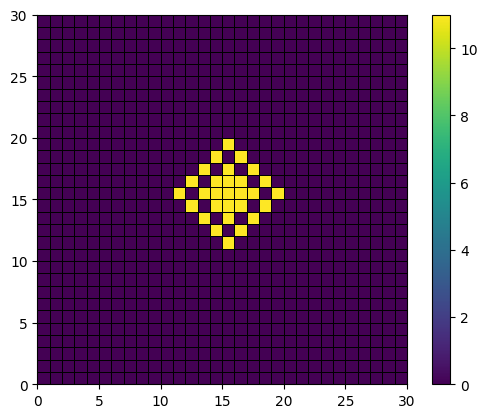

In [ ]:
#### visualizing the lattice again

# plt.pcolormesh(lattice, edgecolors='k', linewidth=0.5)
filtered_lattice = np.where(lattice < FIRST_NODE_NUMBER, lattice, MAX_SOLVENT_MOLECULES * 1.1)
# pc = plt.pcolormesh(filtered_lattice[5:8,13:17], edgecolors='k', linewidth=0.5)
pc = plt.pcolormesh(filtered_lattice, edgecolors='k', linewidth=0.5)
ax = plt.gca()
ax.set_aspect('equal')
plt.colorbar(pc)

# images_dir = '/content/drive/My Drive/Images/'
# plt.savefig(f"{images_dir}test_1000.png")

Text(0, 0.5, 'Number of cells')

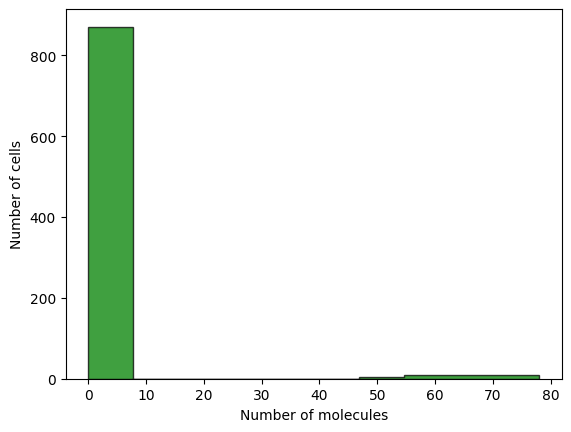

In [ ]:
lattice_1d = lattice.flatten()
plt.hist(lattice_1d, histtype='stepfilled', facecolor='green', alpha=0.75, ec="k")
plt.xlabel('Number of molecules')
plt.ylabel('Number of cells')

In [ ]:
stat_data()

(1.2100767390069582, 0.0)

In [ ]:
# nx.draw(gel_graph, with_labels=True) # font_weight='bold'

In [ ]:
# plt.imshow(lattice, interpolation='none')
# plt.imshow(np.where(lattice < FIRST_NODE_NUMBER, lattice, 0), interpolation='none')
# plt.imshow(np.where(lattice < FIRST_NODE_NUMBER, lattice, 0), interpolation='spline16')
# plt.imshow(lattice, interpolation='spline16')

In [ ]:
stat_data()

(1.2100767390069582, 0.0)

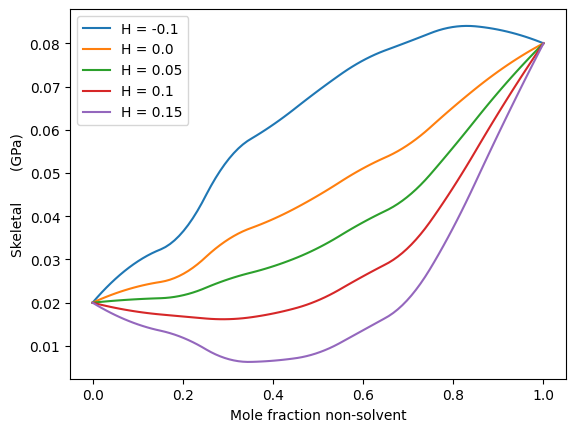

In [ ]:
### VISUALISAZTION FOR MADRID

from scipy.interpolate import interp1d

# SC 1.0 WP -2.0 SP 1.0

E_skel_hydrogel = 0.02
E_skel_alcogel = 0.08
H_param = [-0.10, 0.0, 0.05, 0.1, 0.15]

non_solvent_bulk = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
water_fiber = [1.000, 0.938, 0.890, 0.757, 0.678, 0.587, 0.482, 0.391, 0.246, 0.108, 0.000]

for h in H_param:

    E_fiber = []

    for wf in water_fiber:
        E_fiber.append( E_skel_hydrogel* wf + E_skel_alcogel * (1 - wf) - h * wf * (1 - wf) )

    # data smoothing
    non_solvent_bulk_smooth = np.linspace(0.0, 1.0, num=100, endpoint=True)
    E_fiber_smooth = interp1d(non_solvent_bulk, E_fiber, kind='quadratic')

    plt.plot(non_solvent_bulk_smooth, E_fiber_smooth(non_solvent_bulk_smooth), label = 'H = ' + str(h))

plt.xlabel('Mole fraction non-solvent')
plt.ylabel('Skeletal       (GPa)')
plt.legend(loc='best')

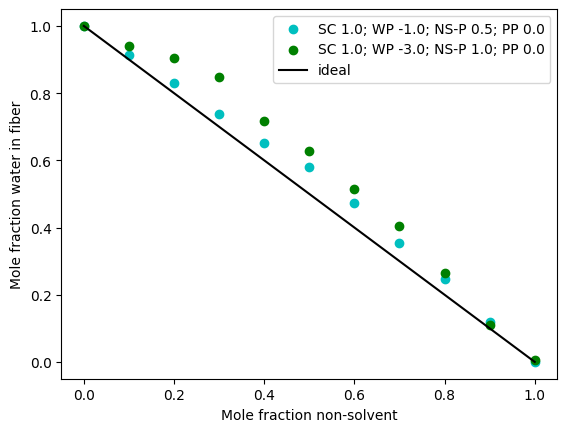

In [ ]:
### VISUALISAZTION FOR MADRID

non_solvent_bulk = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
water_in_fiber_1 = [1.000, 0.914, 0.831, 0.738, 0.652, 0.580, 0.472, 0.354, 0.247, 0.118, 0.000]
water_in_fiber_2 = [1.000, 0.938, 0.890, 0.757, 0.678, 0.587, 0.482, 0.391, 0.246, 0.108, 0.000]
water_in_fiber_3 = [1.000, 0.939, 0.906, 0.848, 0.718, 0.629, 0.516, 0.405, 0.266, 0.109, 0.006]

plt.scatter(non_solvent_bulk, water_in_fiber_1, label = 'SC 1.0; WP -1.0; NS-P 0.5; PP 0.0', c='c')
# plt.scatter(non_solvent_bulk, water_in_fiber_2, label = 'SC 1.0; WP -2.0; NS-P 1.0; PP 0.0', c='b')
plt.scatter(non_solvent_bulk, water_in_fiber_3, label = 'SC 1.0; WP -3.0; NS-P 1.0; PP 0.0', c='g')


plt.plot([0.0, 1.0], [1.0, 0.0], c='k', label = 'ideal')

plt.xlabel('Mole fraction non-solvent')
plt.ylabel('Mole fraction water in fiber')
plt.legend(loc='best')

11
11 11


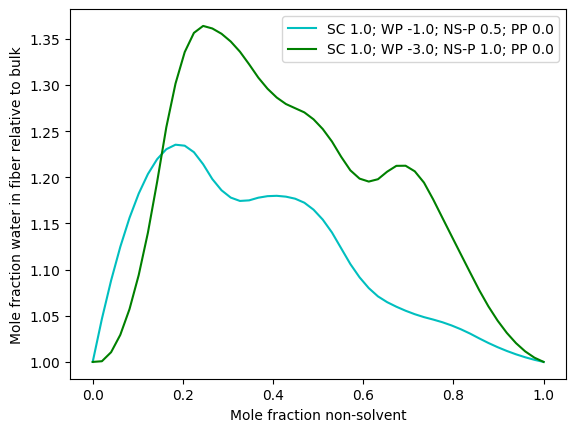

In [ ]:
### VISUALISAZTION FOR MADRID

non_solvent_bulk = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
water_in_fiber_1 = [1.000, 0.914, 0.831, 0.738, 0.652, 0.580, 0.472, 0.354, 0.247, 0.118, 0.000]
water_in_fiber_3 = [1.000, 0.939, 0.906, 0.848, 0.718, 0.629, 0.516, 0.405, 0.266, 0.109, 0.006]

water_bulk = [1 - x for x in non_solvent_bulk]
print(len(water_bulk))

rel_water_increase_1 = []
rel_water_increase_3 = []

for i in range(len(water_bulk) - 1):
    rel_water_increase_1.append(water_in_fiber_1[i] / water_bulk[i])
    rel_water_increase_3.append(water_in_fiber_3[i] / water_bulk[i])

rel_water_increase_1.append(1.0)
rel_water_increase_3.append(1.0)

print(len(rel_water_increase_1), len(rel_water_increase_3))

water_bulk_smooth = np.linspace(0.0, 1.0, num=50, endpoint=True)
rel_water_increase_1_smooth = interp1d(water_bulk, rel_water_increase_1, kind='quadratic')
rel_water_increase_3_smooth = interp1d(water_bulk, rel_water_increase_3, kind='quadratic')

plt.plot(water_bulk_smooth, rel_water_increase_1_smooth(water_bulk_smooth), label = 'SC 1.0; WP -1.0; NS-P 0.5; PP 0.0', c='c')
plt.plot(water_bulk_smooth, rel_water_increase_3_smooth(water_bulk_smooth), label = 'SC 1.0; WP -3.0; NS-P 1.0; PP 0.0', c='g')


# plt.plot([0.0, 1.0], [1.0, 0.0], c='k', label = 'ideal')

plt.xlabel('Mole fraction non-solvent')
plt.ylabel('Mole fraction water in fiber relative to bulk')
plt.legend(loc='best')

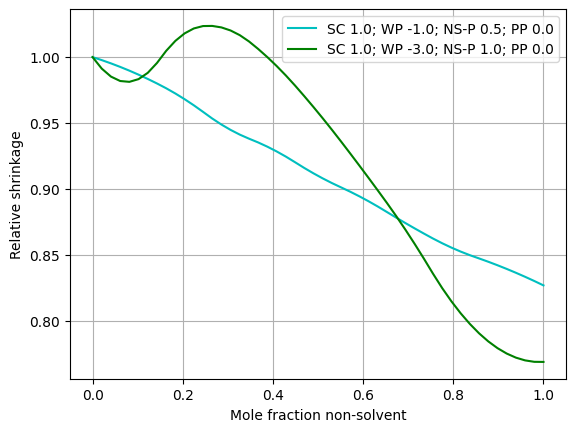

In [ ]:
non_solvent_bulk = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

rel_swelling_1 = [1.000, 0.987, 0.969, 0.946, 0.930, 0.910, 0.893, 0.873, 0.855, 0.842, 0.827]
rel_swelling_3 = [1.000, 0.983, 1.017, 1.021, 0.996, 0.958, 0.914, 0.866, 0.813, 0.779, 0.769]

non_solvent_bulk_smooth = np.linspace(0.0, 1.0, num=50, endpoint=True)
rel_swelling_1_smooth = interp1d(non_solvent_bulk, rel_swelling_1, kind='quadratic')
rel_swelling_3_smooth = interp1d(non_solvent_bulk, rel_swelling_3, kind='quadratic')

plt.plot(non_solvent_bulk_smooth, rel_swelling_1_smooth(non_solvent_bulk_smooth), label = 'SC 1.0; WP -1.0; NS-P 0.5; PP 0.0', c='c')
plt.plot(non_solvent_bulk_smooth, rel_swelling_3_smooth(non_solvent_bulk_smooth), label = 'SC 1.0; WP -3.0; NS-P 1.0; PP 0.0', c='g')

plt.xlabel('Mole fraction non-solvent')
plt.ylabel('Relative shrinkage')
plt.grid()
plt.legend(loc='best')

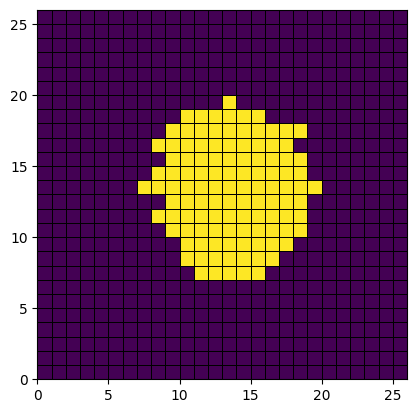

In [ ]:
plt.pcolormesh(lattice_copy, edgecolors='k', linewidth=0.5)
ax = plt.gca()
ax.set_aspect('equal')
plt.colorbar(pc)

In [ ]:
h[2:4] = 8

TypeError: can only assign an iterable

In [ ]:
max_iter = 50000
cnt = 0

while cnt < max_iter:
    random_i, random_j = np.random.randint(0, N), np.random.randint(0, M)
    nbs = von_neumann_neighborhood((random_i, random_j), 'periodic')
    random_index = np.random.randint(0, len(nbs))

    # print('WERE')
    # print(lattice[random_i, random_j], lattice[nbs[random_index]])

    k, m = vanag_diffusion(lattice[random_i, random_j], lattice[nbs[random_index]], 1/2)
    lattice[random_i, random_j], lattice[nbs[random_index]] = k, m

    # print('NOW')
    # print(lattice[random_i, random_j], lattice[nbs[random_index]])

    cnt+=1

In [ ]:
import numpy as np
import scipy.integrate as integrate
result = integrate.quad(lambda x: x * x * np.exp(-x) * np.sin(x) , 1.0, 3.0)
print(result)

(0.763739007630775, 8.479206310760545e-15)

In [ ]:
### Four runs with all possible pairwise combinations

M_even_ind = [j for j in range(M) if j%2 == 0]
N_even_ind = [i for i in range(N) if i%2 == 0]

# horizontal start at (0, 0)
for i in range(N):
    for j in M_even_ind:
        coords = ((i, j), (i, j + 1))
        interacting_nbs_0 = [x for x in von_neumann_neighborhood(coords[0], 'periodic') if x not in coords]
        interacting_nbs_1 = [x for x in von_neumann_neighborhood(coords[1], 'periodic') if x not in coords]

        print(coords)
        print(interacting_nbs_0)
        print(interacting_nbs_1)
        print('---------')



# # vertical start at (0, 0)
# for j in range(M):
#     for i in N_even_ind:
#         print((i, j), (i + 1, j))

# print('++++++++++')

# # horizontal start at (0, 1)
# for i in range(N):
#     for j in M_even_ind:
#         print((i, j + 1), (i, (j + 2) % M))
#     print('-------')

# # vertical start at (1, 0)
# for j in range(M):
#     for i in N_even_ind:
#         print((i + 1, j), ((i + 2) % N, j))
#     print('-------')

((0, 0), (0, 1))
[(9, 0), (1, 0), (0, 9)]
[(9, 1), (1, 1), (0, 2)]
---------
((0, 2), (0, 3))
[(9, 2), (1, 2), (0, 1)]
[(9, 3), (1, 3), (0, 4)]
---------
((0, 4), (0, 5))
[(9, 4), (1, 4), (0, 3)]
[(9, 5), (1, 5), (0, 6)]
---------
((0, 6), (0, 7))
[(9, 6), (1, 6), (0, 5)]
[(9, 7), (1, 7), (0, 8)]
---------
((0, 8), (0, 9))
[(9, 8), (1, 8), (0, 7)]
[(9, 9), (1, 9), (0, 0)]
---------
((1, 0), (1, 1))
[(0, 0), (2, 0), (1, 9)]
[(0, 1), (2, 1), (1, 2)]
---------
((1, 2), (1, 3))
[(0, 2), (2, 2), (1, 1)]
[(0, 3), (2, 3), (1, 4)]
---------
((1, 4), (1, 5))
[(0, 4), (2, 4), (1, 3)]
[(0, 5), (2, 5), (1, 6)]
---------
((1, 6), (1, 7))
[(0, 6), (2, 6), (1, 5)]
[(0, 7), (2, 7), (1, 8)]
---------
((1, 8), (1, 9))
[(0, 8), (2, 8), (1, 7)]
[(0, 9), (2, 9), (1, 0)]
---------
((2, 0), (2, 1))
[(1, 0), (3, 0), (2, 9)]
[(1, 1), (3, 1), (2, 2)]
---------
((2, 2), (2, 3))
[(1, 2), (3, 2), (2, 1)]
[(1, 3), (3, 3), (2, 4)]
---------
((2, 4), (2, 5))
[(1, 4), (3, 4), (2, 3)]
[(1, 5), (3, 5), (2, 6)]
---------

In [ ]:
from google.colab import files
upload = files.upload()

Saving image3.bmp to image3.bmp


time = 0.0
time = 1.0
time = 2.0
time = 3.0
time = 4.0
time = 5.0
time = 6.0
time = 7.0
time = 8.0
time = 9.0
time = 10.0
time = 11.0
time = 12.0
time = 13.0
time = 14.0
time = 15.0
time = 16.0
time = 17.0
time = 18.0
time = 19.0
time = 20.0
time = 21.0
time = 22.0
time = 23.0
time = 24.0
time = 25.0
time = 26.0
time = 27.0
time = 28.0
time = 29.0
time = 30.0
time = 31.0
time = 32.0
time = 33.0
time = 34.0
time = 35.0
time = 36.0
time = 37.0
time = 38.0
time = 39.0
time = 40.0
time = 41.0
time = 42.0
time = 43.0
time = 44.0
time = 45.0
time = 46.0
time = 47.0
time = 48.0
time = 49.0
time = 50.0
time = 51.0
time = 52.0
time = 53.0
time = 54.0
time = 55.0
time = 56.0
time = 57.0
time = 58.0
time = 59.0
time = 60.0
time = 61.0
time = 62.0
time = 63.0
time = 64.0
time = 65.0
time = 66.0
time = 67.0
time = 68.0
time = 69.0
time = 70.0
time = 71.0
time = 72.0
time = 73.0
time = 74.0
time = 75.0
time = 76.0
time = 77.0
time = 78.0
time = 79.0
time = 80.0
time = 81.0
time = 82.0
time = 83.0
ti

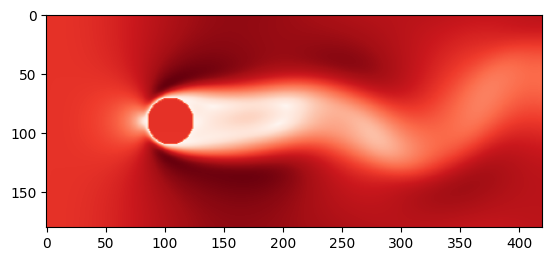

In [ ]:
# Copyright (C) 2015 Universite de Geneve, Switzerland
# E-mail contact: jonas.latt@unige.ch
#
# 2D flow around a cylinder
#

from numpy import *
import matplotlib.pyplot as plt
from matplotlib import cm

###### Flow definition #########################################################
maxIter = 200000  # Total number of time iterations.
Re = 30.0         # Reynolds number.
nx, ny = 420, 180 # Numer of lattice nodes.
ly = ny-1         # Height of the domain in lattice units.
cx, cy, r = nx//4, ny//2, ny//9 # Coordinates of the cylinder.
uLB     = 0.04                  # Velocity in lattice units.
nulb    = uLB*r/Re;             # Viscoscity in lattice units.
omega = 1 / (3*nulb+0.5);    # Relaxation parameter.

###### Lattice Constants #######################################################
v = array([ [ 1,  1], [ 1,  0], [ 1, -1], [ 0,  1], [ 0,  0],
            [ 0, -1], [-1,  1], [-1,  0], [-1, -1] ])
t = array([ 1/36, 1/9, 1/36, 1/9, 4/9, 1/9, 1/36, 1/9, 1/36])

col1 = array([0, 1, 2])
col2 = array([3, 4, 5])
col3 = array([6, 7, 8])

###### Function Definitions ####################################################
def macroscopic(fin):
    rho = sum(fin, axis=0)
    u = zeros((2, nx, ny))
    for i in range(9):
        u[0,:,:] += v[i,0] * fin[i,:,:]
        u[1,:,:] += v[i,1] * fin[i,:,:]
    u /= rho
    return rho, u

def equilibrium(rho, u):              # Equilibrium distribution function.
    usqr = 3/2 * (u[0]**2 + u[1]**2)
    feq = zeros((9,nx,ny))
    for i in range(9):
        cu = 3 * (v[i,0]*u[0,:,:] + v[i,1]*u[1,:,:])
        feq[i,:,:] = rho*t[i] * (1 + cu + 0.5*cu**2 - usqr)
    return feq

###### Setup: cylindrical obstacle and velocity inlet with perturbation ########
# Creation of a mask with 1/0 values, defining the shape of the obstacle.
def obstacle_fun(x, y):
    return (x-cx)**2+(y-cy)**2<r**2

obstacle = fromfunction(obstacle_fun, (nx,ny))

# Initial velocity profile: almost zero, with a slight perturbation to trigger
# the instability.
def inivel(d, x, y):
    return (1-d) * uLB * (1 + 1e-4*sin(y/ly*2*pi))

vel = fromfunction(inivel, (2,nx,ny))

# Initialization of the populations at equilibrium with the given velocity.
fin = equilibrium(1, vel)

###### Main time loop ##########################################################
for time in range(maxIter):

    if time % 2000 == 0:
        print(f'time = {time / 2000}')

    # Right wall: outflow condition.
    fin[col3,-1,:] = fin[col3,-2,:]

    # Compute macroscopic variables, density and velocity.
    rho, u = macroscopic(fin)

    # Left wall: inflow condition.
    u[:,0,:] = vel[:,0,:]
    rho[0,:] = 1/(1-u[0,0,:]) * ( sum(fin[col2,0,:], axis=0) +
                                  2*sum(fin[col3,0,:], axis=0) )
    # Compute equilibrium.
    feq = equilibrium(rho, u)
    fin[[0,1,2],0,:] = feq[[0,1,2],0,:] + fin[[8,7,6],0,:] - feq[[8,7,6],0,:]

    # Collision step.
    fout = fin - omega * (fin - feq)

    # Bounce-back condition for obstacle.
    for i in range(9):
        fout[i, obstacle] = fin[8-i, obstacle]

    # Streaming step.
    for i in range(9):
        fin[i,:,:] = roll(
                            roll(fout[i,:,:], v[i,0], axis=0),
                            v[i,1], axis=1 )

    # Visualization of the velocity.
    if (time%10000==0):
        plt.clf()
        plt.imshow(sqrt(u[0]**2+u[1]**2).transpose(), cmap=cm.Reds)
        plt.savefig("vel.{0:04d}.png".format(time//100))


In [ ]:
x_1_0 = 0.0
x_2_0 = 1.0E6

m_1 = 1.0E20
m_2 = 1.0E12

G = 6.67408E-11

delta_t = 1000.0

G_m_1_m_2 = G * m_1 * m_2

In [ ]:
v_1_half = 6.67408E-8
v_2_half = -6.67408

In [ ]:
print(x_1_delta_t - x_2_delta_t)

-993325.9199332593


-6764066549.305524


979887.7734506945
